In [3]:
import os
import traceback
import requests
from bs4 import BeautifulSoup
from pybliometrics.scopus import ScopusSearch, AbstractRetrieval
import json
from tqdm import tqdm
import pandas as pd
from datetime import datetime, timedelta
import pybliometrics
pybliometrics.scopus.init()
import arxiv
import pandas as pd
from openai import OpenAI
from habanero import Crossref
import warnings
warnings.filterwarnings("ignore")

# Get today's date and the date one month ago
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=30)).strftime('%Y-%m-%d')


def retrieve_arxiv_data(max_results=400):
    
    # Define the list of keywords to search for
    keywords = ["Africa", "Nigeria", "Kenya", "Ghana", "South Africa", "Liberia", "Egypt", "Lagos", "Abuja", "Morocco", "Rwanda", "Senegal", "Sub-Saharan Africa"]

    # Construct the OR-based search query
    query = " OR ".join(keywords)

    search = arxiv.Search(
        query=query,
        max_results=max_results,
        # sort_by=arxiv.SortCriterion.SubmittedDate
    )

    new_data = []
    for result in search.results():
        new_data.append({
          "Title": result.title,
          "Author": result.authors,
          "Publication_Year": str(result.published.date()),
          "Link": result.pdf_url,
          "Abstract": result.summary
        })

    arxiv_df = pd.DataFrame(new_data)

    # Clean the author column
    def clean_authors(x):
        author_list = []
        for i in x:
            author_list.append(i.name)
        author_string = ", ".join(author_list)
        return author_string
    
    arxiv_df["Author"] = arxiv_df["Author"].map(clean_authors)
    
    # Filter out the Publication Date
    arxiv_df["Publication_Year"].astype(str)
    arxiv_df = arxiv_df[(arxiv_df["Publication_Year"] >= "2015-01-01") & (arxiv_df["Publication_Year"] <= str(end_date))]

    # Reset the index of the Dataframe
    arxiv_df = arxiv_df.reset_index(drop=True)

    # Add the ArXiv column
    arxiv_df["Repository"] = "arxiv"

    # Return the dataframe
    return arxiv_df

def retrieve_scopus_data():
    # Define the query
    query = '''
            (TITLE-ABS-KEY(("knowledge production" OR "research output" OR "academic publishing") AND (Africa OR Nigeria OR Kenya OR Ghana OR South Africa OR Liberia OR Egypt OR Lagos OR Abuja OR Morocco OR Rwanda OR Senegal OR "Sub-Saharan Africa"))) 
            AND DOCTYPE(ar) 
            AND SRCTYPE(j) 
            AND PUBYEAR > 2014 AND PUBYEAR < 2026
            '''

    # Perform Scopus search
    x = ScopusSearch(query=query, view="STANDARD", cursor=None, verbose=True)
    
    # Extract results
    scopus_data = []
    for result in x.results:
        scopus_data.append({
            "Title": result.title,
            "Author": result.creator,
            "Publication_Year": result.coverDate,
            "Link": f"http://dx.doi.org/{result.doi}" if result.doi else "No DOI available"
        })
    
    scopus_df = pd.DataFrame(scopus_data)

    # Ensure only results within the date range
    scopus_df = scopus_df[
        (scopus_df["Publication_Year"] >= "2015-01-01") & 
        (scopus_df["Publication_Year"] <= end_date)
    ].reset_index(drop=True)

    # Fetch abstracts using Crossref from Habanero
    cr = Crossref()
    abstracts = []
    
    for link in scopus_df["Link"]:
        if "No DOI available" in link:
            abstracts.append("No abstract available")
            continue
        
        doi = link.split("doi.org/")[-1]
        try:
            paper = cr.works(ids=doi)
            abstract_raw = paper["message"].get("abstract", "No abstract available")
            soup = BeautifulSoup(abstract_raw, "html.parser")
            abstracts.append(soup.get_text())
        except Exception as e:
            abstracts.append("No abstract available")  # Handle errors gracefully

    scopus_df["Abstract"] = abstracts

    # Remove rows with no abstracts
    scopus_df = scopus_df[scopus_df["Abstract"] != "No abstract available"]

     # Add the scopus column
    scopus_df["Repository"] = "scopus"


    # return the dataframe
    return scopus_df

# Merge both dataframes together
def merge_dataframes():
    df_1 = retrieve_arxiv_data()
    df_2 = retrieve_scopus_data()
    df = pd.concat([df_1, df_2], axis = 0)

    # Reset the index
    df = df.reset_index(drop=True)
    return df

df = merge_dataframes()

In [4]:
df.head()

,Title,Author,Publication_Year,Link,Abstract,Repository
0,A Continent-Wide Assessment of Cyber Vulnerabi...,"Abdijabar Yussuf Mohamed, Samuel Kang'ara Kamau",2023-01-08,http://arxiv.org/pdf/2301.03008v1,As the internet penetration rate in Africa inc...,arxiv
1,Physics Masterclasses in Africa and the World,"Uta Bilow, Kenneth Cecire",2022-05-24,http://arxiv.org/pdf/2206.07004v1,International Masterclasses (IMC) enable high ...,arxiv
2,Modelling spatio-temporal trends of air pollut...,"Paterne Gahungu, Jean Remy Kubwimana, Lionel J...",2022-08-21,http://arxiv.org/pdf/2208.12719v1,Atmospheric pollution remains one of the major...,arxiv
3,Radio astronomy in Africa: the case of Ghana,"Bernard Duah Asabere, Michael Gaylard, Cathy H...",2015-03-30,http://arxiv.org/pdf/1503.08850v2,South Africa has played a leading role in radi...,arxiv
4,Modelling the impact of vaccination on the COV...,"Dephney Mathebula, Abigail Amankwah, Kossi Amo...",2022-09-19,http://arxiv.org/pdf/2209.08694v4,The rapid development of vaccines to combat th...,arxiv


Checking the shape of the dataset

In [5]:
df.shape

(257, 6)

Checking for duplicate rows

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
from dotenv import load_dotenv
import os

load_dotenv()

def categorize_topics():
    # Set up OpenAI API client
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    topic_category = []
    for title in df["Title"]:
        # Query OpenAI API for topic categorization
        completion = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "You are an academic assistant. Given a research paper title, classify it into a relevant academic category. Your response should only contain the category name."
                },
                {
                    "role": "user",
                    "content": f"Categorize the research paper titled: '{title}'. Only return the topic category."
                }
            ],
            temperature=0 
        )

        # Extract and print topic categorization
        topic_categorization = completion.choices[0].message.content.strip()
        topic_category.append(topic_categorization)

    # Merge topic categories to the dataframe
    df["Topic_Category"] = topic_category

    # Reset the index of the dataframe
    df.reset_index(drop=True, inplace=True)

    # Return the dataframe with topic categories
    return df

In [8]:
df = categorize_topics()

In [7]:
# !pipx install --force poetry

In [9]:
df.head()

,Title,Author,Publication_Year,Link,Abstract,Repository,Topic_Category
0,A Continent-Wide Assessment of Cyber Vulnerabi...,"Abdijabar Yussuf Mohamed, Samuel Kang'ara Kamau",2023-01-08,http://arxiv.org/pdf/2301.03008v1,As the internet penetration rate in Africa inc...,arxiv,Cybersecurity
1,Physics Masterclasses in Africa and the World,"Uta Bilow, Kenneth Cecire",2022-05-24,http://arxiv.org/pdf/2206.07004v1,International Masterclasses (IMC) enable high ...,arxiv,Physics Education
2,Modelling spatio-temporal trends of air pollut...,"Paterne Gahungu, Jean Remy Kubwimana, Lionel J...",2022-08-21,http://arxiv.org/pdf/2208.12719v1,Atmospheric pollution remains one of the major...,arxiv,Environmental Science
3,Radio astronomy in Africa: the case of Ghana,"Bernard Duah Asabere, Michael Gaylard, Cathy H...",2015-03-30,http://arxiv.org/pdf/1503.08850v2,South Africa has played a leading role in radi...,arxiv,Astronomy
4,Modelling the impact of vaccination on the COV...,"Dephney Mathebula, Abigail Amankwah, Kossi Amo...",2022-09-19,http://arxiv.org/pdf/2209.08694v4,The rapid development of vaccines to combat th...,arxiv,Epidemiology


In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df.isna().sum()

Title               0
Author              0
Publication_Year    0
Link                0
Abstract            0
Repository          0
Topic_Category      0
dtype: int64

In [11]:
# df["Abstract"].unique()

In [47]:
df.to_csv("Automated_Newsletter_Research_Dataset.csv")

In [1]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Rise Networks\Desktop\Automated_Newsletter\notebooks\Automated_Newsletter_Research_Dataset.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,Title,Author,Publication_Year,Link,Abstract,Repository,Topic_Category,Year,Country(s)
0,0,0,A Continent-Wide Assessment of Cyber Vulnerabi...,"Abdijabar Yussuf Mohamed, Samuel Kang'ara Kamau",2023-01-08,http://arxiv.org/pdf/2301.03008v1,As the internet penetration rate in Africa inc...,arxiv,Cybersecurity,2023,"South Africa, Tunisia, Morocco, Egypt, Nigeria"
1,1,1,Physics Masterclasses in Africa and the World,"Uta Bilow, Kenneth Cecire",2022-05-24,http://arxiv.org/pdf/2206.07004v1,International Masterclasses (IMC) enable high ...,arxiv,Physics Education,2022,"Egypt, Algeria, Morocco, Sao Tomé and Principe..."
2,2,2,Modelling spatio-temporal trends of air pollut...,"Paterne Gahungu, Jean Remy Kubwimana, Lionel J...",2022-08-21,http://arxiv.org/pdf/2208.12719v1,Atmospheric pollution remains one of the major...,arxiv,Environmental Science,2022,"Africa, Nigeria, Uganda, Rwanda, Chad"
3,3,3,Radio astronomy in Africa: the case of Ghana,"Bernard Duah Asabere, Michael Gaylard, Cathy H...",2015-03-30,http://arxiv.org/pdf/1503.08850v2,South Africa has played a leading role in radi...,arxiv,Astronomy,2015,"South Africa, Ghana"
4,4,4,Modelling the impact of vaccination on the COV...,"Dephney Mathebula, Abigail Amankwah, Kossi Amo...",2022-09-19,http://arxiv.org/pdf/2209.08694v4,The rapid development of vaccines to combat th...,arxiv,Epidemiology,2022,"Ghana, Kenya, Mozambique, Nigeria, South Afric..."


In [2]:
df.shape

(257, 11)

In [3]:
# How many papers are from ArXiv and Scopus
df["Repository"].value_counts()

Repository
arxiv     211
scopus     46
Name: count, dtype: int64

In [4]:
# What is the time range of the articles
min_publicate_date = df["Publication_Year"].min()
max_publication_date = df["Publication_Year"].max()

print(f"The publication range of the articles is between {min_publicate_date} and {max_publication_date}")

The publication range of the articles is between 2015-01-22 and 2025-05-20


In [5]:
# breakdown of number of articles per year
df["Year"] = df["Publication_Year"].str.split("-").str[0]

df["Year"].value_counts().sort_values(ascending=True)

Year
2017     8
2018    11
2019    14
2015    16
2016    17
2021    24
2024    25
2025    29
2023    33
2020    36
2022    44
Name: count, dtype: int64

In [6]:
# How many unique themes did GPT 4 produce?
df["Topic_Category"].nunique()

76

In [7]:
# What are the top five most common thematic categories
top_5_common_themes = df["Topic_Category"].value_counts().sort_values(ascending=False).index[:5].to_list()

# How many articles fall into each?
top_5_common_themes_articles = df["Topic_Category"].value_counts().sort_values(ascending=False).values[:5]

for theme, number_of_articles in zip(top_5_common_themes, top_5_common_themes_articles):
    print(f"{theme} ---> {number_of_articles}")

Computer Science ---> 25
Astrophysics ---> 17
Economics ---> 15
Epidemiology ---> 15
Physics ---> 15


THEMATIC MAPPING

Geographical Mapping

In [ ]:
# zero-shot prompt
from dotenv import load_dotenv
import os

load_dotenv()

def identify_countries():
    # Set up OpenAI API client
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    country = []
    for title, abstract in zip(df["Title"], df["Abstract"]):
        # Query OpenAI API for topic categorization
        completion = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "You are an academic assistant. Given a research paper title and abstract, identify the African country(s) mentioned in the abstract. Your response should only contain the African country name(s)."
                },
                {
                    "role": "user",
                    "content": f"""
                                    Extract the African country name(s) from the title: '{title}' and abstract: '{abstract}'. Only return the African country name(s) if none, return "None". 
                                    Note: The African country of focus can be a single African country. If no African country return "None"
                                """
                }
            ],
            temperature=0 
        )

        # Extract and print topic categorization
        model_result = completion.choices[0].message.content.strip()
        country.append(model_result)

    # Merge topic categories to the dataframe
    df["Country(s)"] = country

    # Reset the index of the dataframe
    df.reset_index(drop=True, inplace=True)

    # Return the dataframe with topic categories
    return df

In [8]:
# Fewshot prompt using langchain
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv
from tqdm import tqdm

# Load environment variables
load_dotenv()
# creating prompt
prompt = ChatPromptTemplate.from_messages([
    (
        "system", 
        """
        You are a topic categorizer. Your task is to assign each research topic to a broad academic or professional discipline.

        Use concise and general categories such as "Cybersecurity", "Physics Education", "Environmental Science", "Health Policy", "Artificial Intelligence", etc.

        Respond with only the category name.

        Examples:

        Topic: A Continent-Wide Assessment of Cyber Vulnerability Across Africa  
        Category: Cybersecurity

        Topic: Physics Masterclasses in Africa and the World  
        Category: Physics Education
        """
    ),
    ("human", "Topic: {topic}")
])

llm = ChatOpenAI(model="gpt-4o", max_retries=2, api_key=os.getenv("OPENAI_API_KEY"))

chain = prompt | llm

llm_category_fewshot = []

for topics in tqdm(df["Title"], total=len(df), desc="Processing Papers"):
    answer = chain.invoke(
        {
            "topic": f"{topics}"
        }
    )
    llm_category_fewshot.append(answer.content)

Processing Papers: 100%|██████████| 257/257 [03:10<00:00,  1.35it/s]


In [9]:
llm_category_fewshot_cleaned = []
for i in llm_category_fewshot:
    i = i.split(":")[-1]
    i = i.strip(" ").strip("")
    llm_category_fewshot_cleaned.append(i)

In [10]:
#Append the few-shot answers to the dataset
df["Topic_Category_Fewshot"] = llm_category_fewshot_cleaned

In [11]:
# Fewshot with CoT prompt using langchain
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv
from tqdm import tqdm

# Load environment variables
load_dotenv()
# creating prompt
prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """
        You are a topic categorizer. Your job is to assign a broad academic or professional discipline to each research topic.

        For each topic, think step-by-step about what the subject area is about, and then output the final category.

        Respond with a short reasoning followed by:
        Category: <discipline>

        Examples:

        Topic: A Continent-Wide Assessment of Cyber Vulnerability Across Africa  
        This topic discusses digital threats across a continent, focusing on computer networks and risk analysis.  
        Category: Cybersecurity

        Topic: Physics Masterclasses in Africa and the World  
        This involves science outreach and teaching methods related to physics across regions.  
        Category: Physics Education

        Note: You are expected to return or output only the category
        """
    ),
    ("human", "Topic: {topic}")
])

llm = ChatOpenAI(model="gpt-4o", max_retries=2, api_key=os.getenv("OPENAI_API_KEY"))

chain = prompt | llm

llm_category_fewshot_cot = []

for topics in tqdm(df["Title"], total=len(df), desc="Processing Papers"):
    answer = chain.invoke(
        {
            "topic": f"{topics}"
        }
    )
    llm_category_fewshot_cot.append(answer.content)

Processing Papers: 100%|██████████| 257/257 [06:55<00:00,  1.62s/it]


In [12]:
llm_category_fewshot_cot_cleaned = []
for i in llm_category_fewshot_cot:
    i = i.split(":")[-1]
    i = i.strip()
    llm_category_fewshot_cot_cleaned.append(i)

In [13]:
#Append the few-shot with CoT answers to the dataset
df["Topic_Category_Fewshot_COT"] = llm_category_fewshot_cot_cleaned

In [64]:
df = identify_countries()

In [65]:
df.head()

,Unnamed: 0,Title,Author,Publication_Year,Link,Abstract,Repository,Topic_Category,Year,Country(s)
0,0,A Continent-Wide Assessment of Cyber Vulnerabi...,"Abdijabar Yussuf Mohamed, Samuel Kang'ara Kamau",2023-01-08,http://arxiv.org/pdf/2301.03008v1,As the internet penetration rate in Africa inc...,arxiv,Cybersecurity,2023,"South Africa, Tunisia, Morocco, Egypt, Nigeria"
1,1,Physics Masterclasses in Africa and the World,"Uta Bilow, Kenneth Cecire",2022-05-24,http://arxiv.org/pdf/2206.07004v1,International Masterclasses (IMC) enable high ...,arxiv,Physics Education,2022,"Egypt, Algeria, Morocco, Sao Tomé and Principe..."
2,2,Modelling spatio-temporal trends of air pollut...,"Paterne Gahungu, Jean Remy Kubwimana, Lionel J...",2022-08-21,http://arxiv.org/pdf/2208.12719v1,Atmospheric pollution remains one of the major...,arxiv,Environmental Science,2022,"Nigeria, Mali, Uganda, Rwanda, Chad"
3,3,Radio astronomy in Africa: the case of Ghana,"Bernard Duah Asabere, Michael Gaylard, Cathy H...",2015-03-30,http://arxiv.org/pdf/1503.08850v2,South Africa has played a leading role in radi...,arxiv,Astronomy,2015,"Ghana, South Africa"
4,4,Modelling the impact of vaccination on the COV...,"Dephney Mathebula, Abigail Amankwah, Kossi Amo...",2022-09-19,http://arxiv.org/pdf/2209.08694v4,The rapid development of vaccines to combat th...,arxiv,Epidemiology,2022,"Ghana, Kenya, Mozambique, Nigeria, South Afric..."


In [66]:
def extract_all_countries(x):
    list_of_countries = []
    x = x.split(",")
    for i in x:
        list_of_countries.append(i)

    return list(set(list_of_countries))

list_of_countries = df["Country(s)"].map(extract_all_countries)

In [67]:
total_countries = []
for i in list_of_countries:
    for j in i:
        total_countries.append(j)
total_countries = list(set(total_countries))
print(len(total_countries))

55


In [70]:
len(total_countries)

55

Number of papers associated with a country

In [111]:
country_dict = {}
count = 1
for i in range(len(df)):
    for j in total_countries:
        if j in df["Country(s)"][i]:
            if j not in country_dict:
                country_dict[j] = count
            else:
                country_dict[j] = country_dict[j] + count
pd.Series(country_dict).sort_values(ascending=False)[:20]

South Africa     101
None              74
Nigeria           31
Kenya             26
Ghana             21
 Kenya            12
 South Africa     12
Egypt             11
Liberia           10
Uganda             9
Rwanda             8
 Tanzania          8
Guinea             8
 Uganda            7
 Nigeria           7
 Liberia           7
 Sierra Leone      7
Senegal            6
 Egypt             5
Tunisia            4
dtype: int64

Temporal Mapping

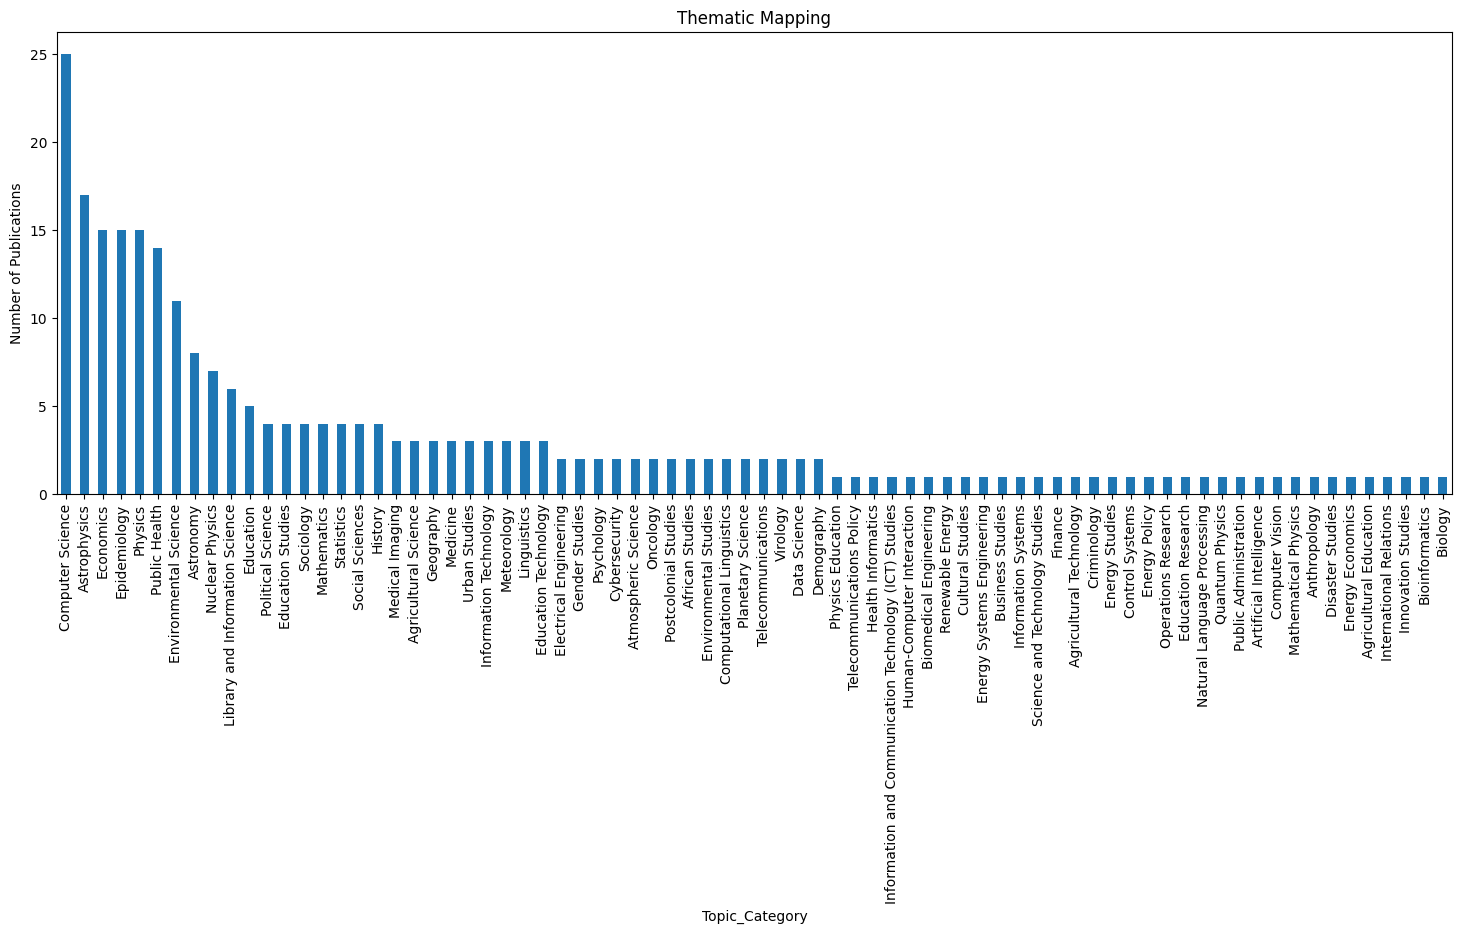

In [74]:
import matplotlib.pyplot as plt

df["Topic_Category"].value_counts().plot(
    kind="bar",
    title="Thematic Mapping",
    ylabel= "Number of Publications",
    figsize = (18, 6)
    )
plt.show()

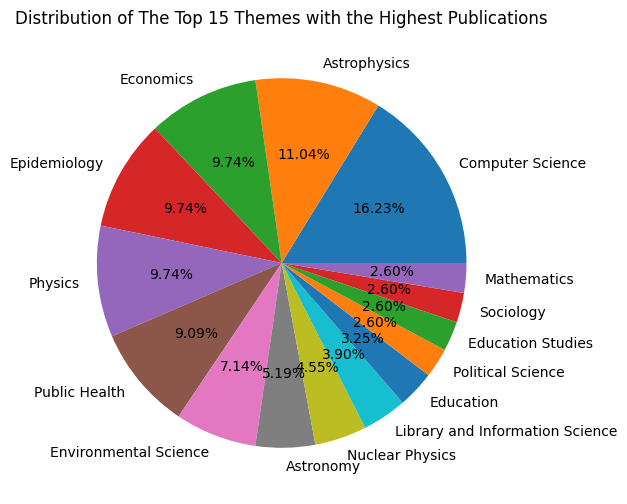

In [75]:
df["Topic_Category"].value_counts()[:15].plot(
    kind="pie",
    title="Distribution of The Top 15 Themes with the Highest Publications",
    autopct = "%.2f%%",
    figsize = (18,6),
    ylabel = ""
)
plt.show()

In [11]:
df["Link"][1]

'http://arxiv.org/pdf/2206.07004v1'

In [12]:
df['Year'] = pd.to_datetime(df['Publication_Year']).dt.year

In [13]:
theme_trends = df.groupby(['Year', 'Topic_Category']).size().reset_index(name='Count')

In [77]:

# Step 1: Count the top 20 most frequent themes
top_20_themes = df['Topic_Category'].value_counts().nlargest(20).index

# Step 2: Filter the dataframe to only include those top 20 themes
df_top_20 = df[df['Topic_Category'].isin(top_20_themes)]

# Optional: Check the result
# print(df_top_20['Topic_Category'].value_counts())
df_top_20 = df_top_20.groupby(["Year", "Topic_Category"]).size().reset_index(name="Count")

In [78]:
# theme_trends = theme_trends.sort_values(by="Count", ascending=False)
# theme_trends = df_top_20.sort_values(by="Count", ascending=False)
df_top_20.head()

,Year,Topic_Category,Count
0,2015,Astronomy,1
1,2015,Economics,1
2,2015,Epidemiology,4
3,2015,Library and Information Science,1
4,2015,Mathematics,2


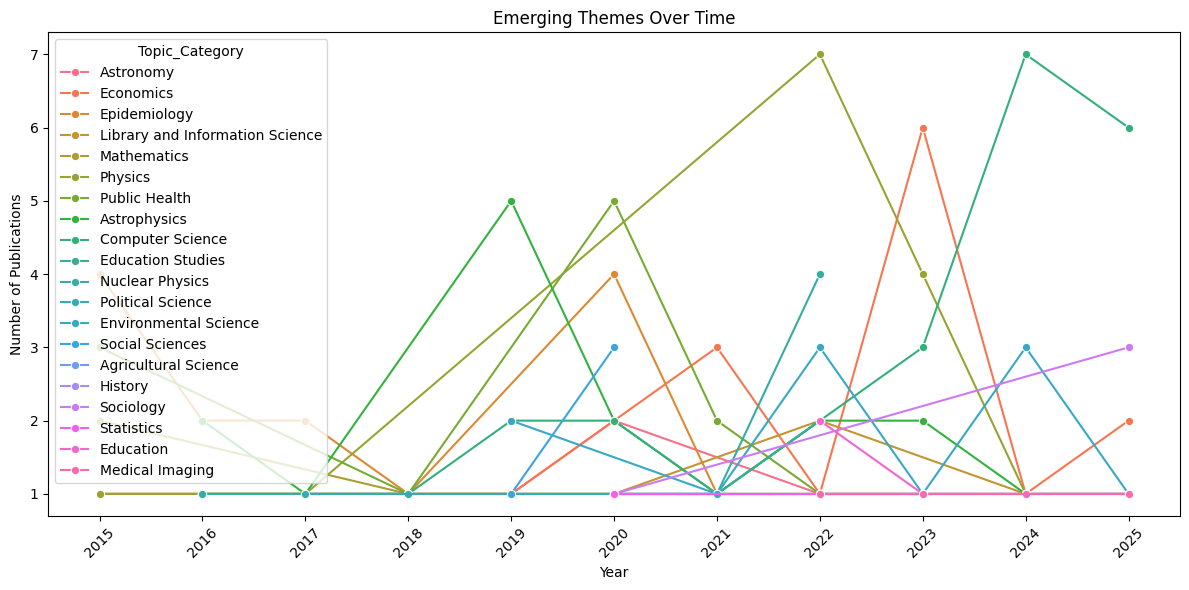

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_top_20, x='Year', y='Count', hue='Topic_Category', marker='o')
plt.title('Emerging Themes Over Time')
plt.ylabel('Number of Publications')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

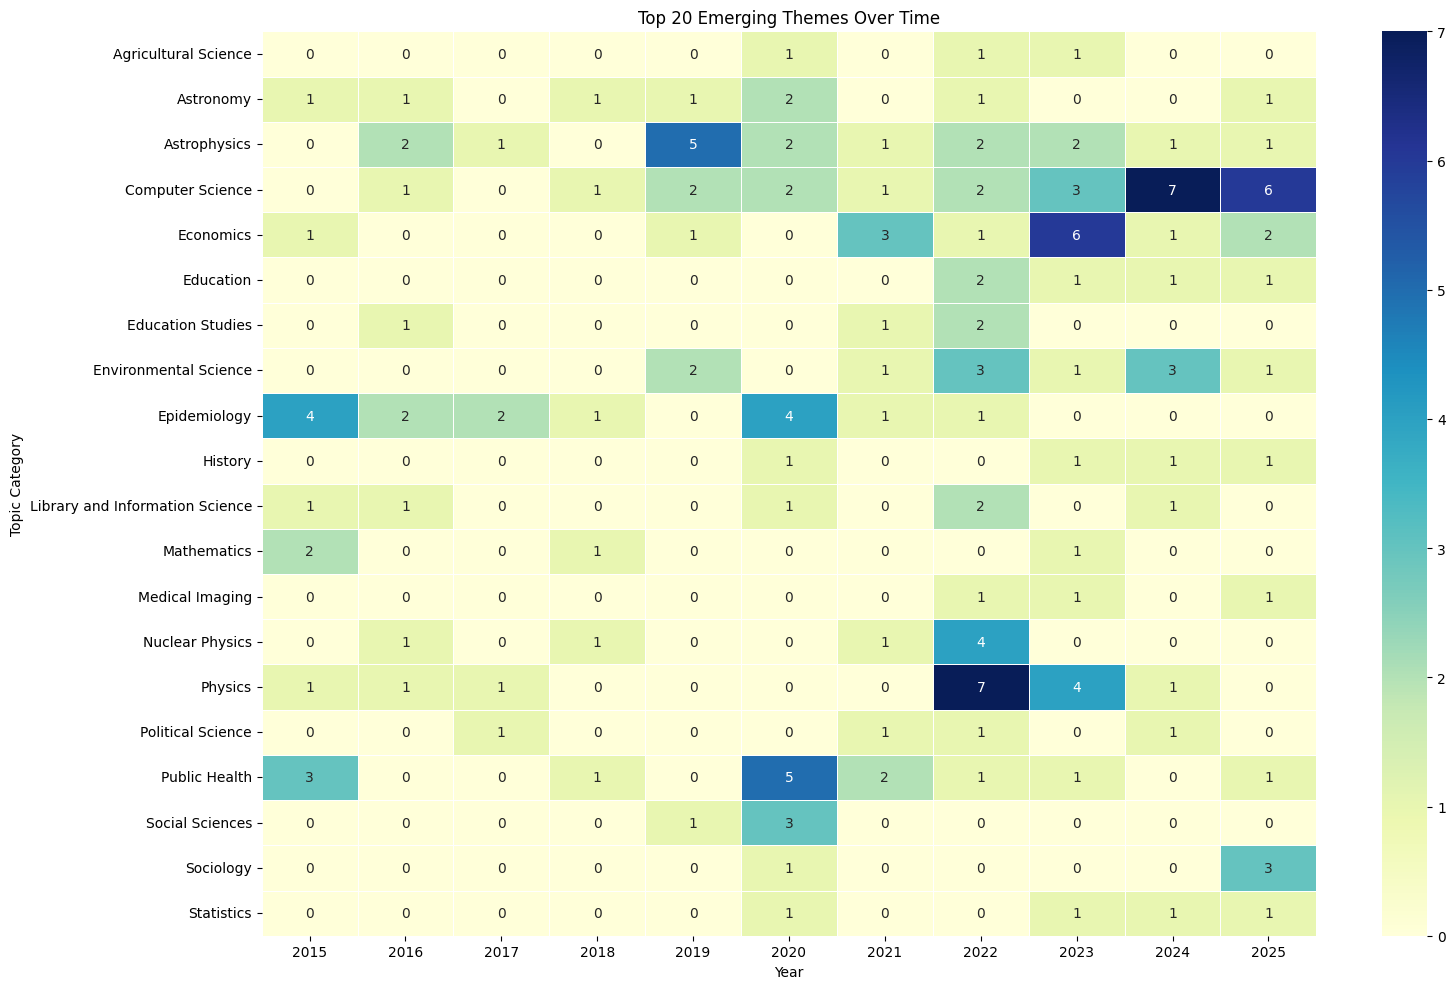

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Convert publication date to year (if needed)
df['Publication_Year'] = pd.to_datetime(df['Publication_Year'], errors='coerce').dt.year

# Step 2: Get top 20 themes
top_20_themes = df['Topic_Category'].value_counts().nlargest(20).index
df_top_20 = df[df['Topic_Category'].isin(top_20_themes)]

# Step 3: Create pivot table (rows=Theme, cols=Year, values=Counts)
heatmap_data = df_top_20.pivot_table(index='Topic_Category',
                                      columns='Publication_Year',
                                      values='Title',  # or any column
                                      aggfunc='count',
                                      fill_value=0)

# Step 4: Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5, annot=True, fmt="d")
plt.title('Top 20 Emerging Themes Over Time')
plt.xlabel('Year')
plt.ylabel('Topic Category')
plt.tight_layout()
plt.show()

TOPIC MODELING USING BERTOPIC

In [18]:
# Clean the titles column
titles = df["Title"].dropna().to_list()

In [29]:
print(len(titles))
research_titles = df["Title"]

253


In [30]:
from bertopic import BERTopic
# "all-MiniLM-L6-v2"
# "paraphrase-MiniLLM-"

In [44]:
model =BERTopic(verbose=True, embedding_model="all-MiniLM-L6-v2", min_topic_size=10, nr_topics=5)

In [45]:
model.fit_transform(research_titles)

2025-04-24 14:46:14,746 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2025-04-24 14:46:25,251 - BERTopic - Embedding - Completed ✓
2025-04-24 14:46:25,257 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-24 14:46:25,963 - BERTopic - Dimensionality - Completed ✓
2025-04-24 14:46:25,965 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-24 14:46:25,983 - BERTopic - Cluster - Completed ✓
2025-04-24 14:46:25,984 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-24 14:46:26,019 - BERTopic - Representation - Completed ✓
2025-04-24 14:46:26,020 - BERTopic - Topic reduction - Reducing number of topics
2025-04-24 14:46:26,021 - BERTopic - Topic reduction - Number of topics (5) is equal or higher than the clustered topics(4).
2025-04-24 14:46:26,025 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-24 14:46:26,178 - BERTopic - Representation - Completed ✓


([2,
  2,
  -1,
  1,
  0,
  2,
  2,
  0,
  -1,
  1,
  2,
  2,
  1,
  2,
  -1,
  2,
  2,
  2,
  2,
  1,
  0,
  2,
  2,
  2,
  2,
  0,
  2,
  2,
  1,
  0,
  2,
  2,
  1,
  2,
  2,
  0,
  -1,
  2,
  2,
  2,
  -1,
  2,
  1,
  0,
  -1,
  2,
  2,
  2,
  2,
  2,
  2,
  0,
  0,
  2,
  2,
  2,
  2,
  2,
  2,
  0,
  2,
  2,
  0,
  0,
  0,
  0,
  2,
  0,
  1,
  1,
  1,
  -1,
  2,
  2,
  1,
  2,
  -1,
  2,
  -1,
  2,
  2,
  -1,
  2,
  2,
  2,
  1,
  2,
  0,
  -1,
  0,
  2,
  2,
  2,
  -1,
  1,
  0,
  2,
  0,
  2,
  2,
  2,
  -1,
  1,
  0,
  2,
  2,
  2,
  2,
  2,
  0,
  0,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  -1,
  2,
  1,
  1,
  0,
  1,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  1,
  2,
  2,
  -1,
  -1,
  1,
  1,
  2,
  2,
  -1,
  1,
  0,
  2,
  0,
  2,
  2,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  2,
  2,
  1,
  0,
  0,
  -1,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  0,
  1,
  2,
  1,
  0,
  0,
  2,
  2,
  

In [46]:
# model.get_topic

In [48]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,22,-1_in_using_of_the,"[in, using, of, the, learning, threshold, nort...",[Predicting Insurance Penetration Rate in Ghan...
1,0,42,0_19_covid_of_the,"[19, covid, of, the, in, to, and, ebola, afric...",[Modelling the impact of vaccination on the CO...
2,1,49,1_the_of_in_and,"[the, of, in, and, radio, giant, on, isoscalar...","[Radio astronomy in Africa: the case of Ghana,..."
3,2,140,2_in_and_of_africa,"[in, and, of, africa, the, for, south, on, res...",[Physics Education for Capacity Development an...


In [49]:
model.topic_representations_

{-1: [('in', np.float64(0.0935493377827508)),
  ('using', np.float64(0.08435485313721941)),
  ('of', np.float64(0.07993324982072599)),
  ('the', np.float64(0.060712108469137986)),
  ('learning', np.float64(0.05701123754381682)),
  ('threshold', np.float64(0.05067924395938736)),
  ('northwest', np.float64(0.05067924395938736)),
  ('image', np.float64(0.05067924395938736)),
  ('war', np.float64(0.05067924395938736)),
  ('africa', np.float64(0.04937349828739871))],
 0: [('19', np.float64(0.11310482202354656)),
  ('covid', np.float64(0.11310482202354656)),
  ('of', np.float64(0.09432123478845666)),
  ('the', np.float64(0.09175603388340657)),
  ('in', np.float64(0.0856460316597253)),
  ('to', np.float64(0.08297527266445064)),
  ('and', np.float64(0.08087505170678941)),
  ('ebola', np.float64(0.06959302789831431)),
  ('africa', np.float64(0.06830568107898057)),
  ('south', np.float64(0.0645176778411558))],
 1: [('the', np.float64(0.10812221451022128)),
  ('of', np.float64(0.09964720615173929

In [57]:
model.get_topic(2)

[('in', np.float64(0.0892710077781855)),
 ('and', np.float64(0.08303425614746875)),
 ('of', np.float64(0.07680368253828597)),
 ('africa', np.float64(0.07668450531553146)),
 ('the', np.float64(0.0627872813265406)),
 ('for', np.float64(0.057875702038936126)),
 ('south', np.float64(0.05297817812345969)),
 ('on', np.float64(0.04564762907282582)),
 ('research', np.float64(0.03277958913981134)),
 ('to', np.float64(0.03187351871034042))]

In [59]:
fig = model.visualize_topics()
fig

TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

In [4]:
# %pip install gensim

Applying Topic Modelling using LDA

In [ ]:
# Preprocessing text data
import re

def clean_abstract(text):
    text = re.sub('\s+', ' ', text)  # Remove extra spaces
    text = re.sub('\'', '', text)  # Remove apostrophes
    text = text.lower() # convert to lowercase

    return text

df["clean_abstract"] = df["Abstract"].apply(clean_abstract)

In [ ]:
# Tokenize and remove stop words
import nltk
import gensim
from nltk.corpus import stopwords

# Download stopwords
nltk.download("stopwords")
stop_words = stopwords.words("english")

# Tokenize and remove stopwords
def tokenize(text):
    tokens_list = []
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    for token in tokens:
        if token not in stop_words:
            tokens_list.append(token)
    
    return tokens_list
    
df["tokens"] = df["clean_abstract"].apply(tokenize)

BERTopic Modelling

In [8]:
# %pip install bertopic

In [9]:
# # Choose an embedding backend
# %pip install bertopic[flair, gensim, spacy, use]

# # Topic modeling with images
# %pip install bertopic[vision]

In [10]:
from bertopic import BERTopic

In [1]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Rise Networks\Desktop\Automated_Newsletter\notebooks\Automated_Newsletter_Research_Dataset.csv")

In [13]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Title,Author,Publication_Year,Link,Abstract,Repository,Topic_Category,Year,Country(s)
0,0,0,A Continent-Wide Assessment of Cyber Vulnerabi...,"Abdijabar Yussuf Mohamed, Samuel Kang'ara Kamau",2023-01-08,http://arxiv.org/pdf/2301.03008v1,As the internet penetration rate in Africa inc...,arxiv,Cybersecurity,2023,"South Africa, Tunisia, Morocco, Egypt, Nigeria"
1,1,1,Physics Masterclasses in Africa and the World,"Uta Bilow, Kenneth Cecire",2022-05-24,http://arxiv.org/pdf/2206.07004v1,International Masterclasses (IMC) enable high ...,arxiv,Physics Education,2022,"Egypt, Algeria, Morocco, Sao Tomé and Principe..."
2,2,2,Modelling spatio-temporal trends of air pollut...,"Paterne Gahungu, Jean Remy Kubwimana, Lionel J...",2022-08-21,http://arxiv.org/pdf/2208.12719v1,Atmospheric pollution remains one of the major...,arxiv,Environmental Science,2022,"Africa, Nigeria, Uganda, Rwanda, Chad"
3,3,3,Radio astronomy in Africa: the case of Ghana,"Bernard Duah Asabere, Michael Gaylard, Cathy H...",2015-03-30,http://arxiv.org/pdf/1503.08850v2,South Africa has played a leading role in radi...,arxiv,Astronomy,2015,"South Africa, Ghana"
4,4,4,Modelling the impact of vaccination on the COV...,"Dephney Mathebula, Abigail Amankwah, Kossi Amo...",2022-09-19,http://arxiv.org/pdf/2209.08694v4,The rapid development of vaccines to combat th...,arxiv,Epidemiology,2022,"Ghana, Kenya, Mozambique, Nigeria, South Afric..."


In [14]:
doc = df["Title"]

In [15]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(doc)

In [16]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,12,-1_of_africa_the_war,"[of, africa, the, war, northwest, during, cape...",[Impact of Culture on the Adoption of Diabetes...
1,0,155,0_in_and_of_africa,"[in, and, of, africa, the, for, south, on, res...",[Social and Economic Impact Analysis of Solar ...
2,1,48,1_the_of_in_and,"[the, of, in, and, giant, radio, on, monopole,...",[Isoscalar giant monopole strength in $^{58}$N...
3,2,42,2_covid19_the_in_of,"[covid19, the, in, of, to, and, ebola, for, af...",[Use of Available Data To Inform The COVID-19 ...


In [17]:
topic_model.get_topic(0)

[('in', np.float64(0.09325385337451579)),
 ('and', np.float64(0.08095017293020317)),
 ('of', np.float64(0.07969995391929527)),
 ('africa', np.float64(0.07025255060964597)),
 ('the', np.float64(0.062482029043755646)),
 ('for', np.float64(0.05599922329572976)),
 ('south', np.float64(0.04888652422983273)),
 ('on', np.float64(0.04497503868214873)),
 ('research', np.float64(0.03366973491426365)),
 ('to', np.float64(0.03201755411955633))]

In [18]:
topic_model.get_document_info(doc)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,A Continent-Wide Assessment of Cyber Vulnerabi...,0,0_in_and_of_africa,"[in, and, of, africa, the, for, south, on, res...",[Social and Economic Impact Analysis of Solar ...,in - and - of - africa - the - for - south - o...,1.000000,False
1,Physics Masterclasses in Africa and the World,0,0_in_and_of_africa,"[in, and, of, africa, the, for, south, on, res...",[Social and Economic Impact Analysis of Solar ...,in - and - of - africa - the - for - south - o...,0.839351,False
2,Modelling spatio-temporal trends of air pollut...,-1,-1_of_africa_the_war,"[of, africa, the, war, northwest, during, cape...",[Impact of Culture on the Adoption of Diabetes...,of - africa - the - war - northwest - during -...,0.000000,False
3,Radio astronomy in Africa: the case of Ghana,-1,-1_of_africa_the_war,"[of, africa, the, war, northwest, during, cape...",[Impact of Culture on the Adoption of Diabetes...,of - africa - the - war - northwest - during -...,0.000000,False
4,Modelling the impact of vaccination on the COV...,2,2_covid19_the_in_of,"[covid19, the, in, of, to, and, ebola, for, af...",[Use of Available Data To Inform The COVID-19 ...,covid19 - the - in - of - to - and - ebola - f...,1.000000,False
...,...,...,...,...,...,...,...,...
252,Information and communication technology as a ...,0,0_in_and_of_africa,"[in, and, of, africa, the, for, south, on, res...",[Social and Economic Impact Analysis of Solar ...,in - and - of - africa - the - for - south - o...,0.985813,False
253,Systematic review on the conservation genetics...,0,0_in_and_of_africa,"[in, and, of, africa, the, for, south, on, res...",[Social and Economic Impact Analysis of Solar ...,in - and - of - africa - the - for - south - o...,0.869449,False
254,Postcolonial Reverberations,0,0_in_and_of_africa,"[in, and, of, africa, the, for, south, on, res...",[Social and Economic Impact Analysis of Solar ...,in - and - of - africa - the - for - south - o...,1.000000,False
255,Publishing patterns at the Cape Peninsula Univ...,0,0_in_and_of_africa,"[in, and, of, africa, the, for, south, on, res...",[Social and Economic Impact Analysis of Solar ...,in - and - of - africa - the - for - south - o...,1.000000,False


In [32]:
from bertopic.representation import KeyBERTInspired

# Fine-tune your topic representations
representation_model = KeyBERTInspired()
topic_model = BERTopic(representation_model=representation_model)

In [33]:
topics, probs = topic_model.fit_transform(doc)

topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,15,-1_altitudes_aviation_continent_africa,"[altitudes, aviation, continent, africa, trips...",[Analysis of Modal Split of Intra-urban Trips ...
1,0,154,0_africa_africas_kenya_nigeria,"[africa, africas, kenya, nigeria, african, cap...",[Social and Economic Impact Analysis of Solar ...
2,1,47,1_monopole_resonance_dipole_isoscalar,"[monopole, resonance, dipole, isoscalar, giant...",[Isoscalar giant monopole strength in $^{58}$N...
3,2,41,2_ebola_epidemic_pandemic_outbreak,"[ebola, epidemic, pandemic, outbreak, covid19,...",[Use of Available Data To Inform The COVID-19 ...


In [34]:
topic_model.get_document_info(doc)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,A Continent-Wide Assessment of Cyber Vulnerabi...,0,0_africa_africas_kenya_nigeria,"[africa, africas, kenya, nigeria, african, cap...",[Social and Economic Impact Analysis of Solar ...,africa - africas - kenya - nigeria - african -...,0.958399,False
1,Physics Masterclasses in Africa and the World,0,0_africa_africas_kenya_nigeria,"[africa, africas, kenya, nigeria, african, cap...",[Social and Economic Impact Analysis of Solar ...,africa - africas - kenya - nigeria - african -...,0.768679,False
2,Modelling spatio-temporal trends of air pollut...,-1,-1_altitudes_aviation_continent_africa,"[altitudes, aviation, continent, africa, trips...",[Analysis of Modal Split of Intra-urban Trips ...,altitudes - aviation - continent - africa - tr...,0.000000,False
3,Radio astronomy in Africa: the case of Ghana,-1,-1_altitudes_aviation_continent_africa,"[altitudes, aviation, continent, africa, trips...",[Analysis of Modal Split of Intra-urban Trips ...,altitudes - aviation - continent - africa - tr...,0.000000,False
4,Modelling the impact of vaccination on the COV...,2,2_ebola_epidemic_pandemic_outbreak,"[ebola, epidemic, pandemic, outbreak, covid19,...",[Use of Available Data To Inform The COVID-19 ...,ebola - epidemic - pandemic - outbreak - covid...,1.000000,False
...,...,...,...,...,...,...,...,...
252,Information and communication technology as a ...,0,0_africa_africas_kenya_nigeria,"[africa, africas, kenya, nigeria, african, cap...",[Social and Economic Impact Analysis of Solar ...,africa - africas - kenya - nigeria - african -...,0.948794,False
253,Systematic review on the conservation genetics...,0,0_africa_africas_kenya_nigeria,"[africa, africas, kenya, nigeria, african, cap...",[Social and Economic Impact Analysis of Solar ...,africa - africas - kenya - nigeria - african -...,0.834549,False
254,Postcolonial Reverberations,0,0_africa_africas_kenya_nigeria,"[africa, africas, kenya, nigeria, african, cap...",[Social and Economic Impact Analysis of Solar ...,africa - africas - kenya - nigeria - african -...,1.000000,False
255,Publishing patterns at the Cape Peninsula Univ...,0,0_africa_africas_kenya_nigeria,"[africa, africas, kenya, nigeria, african, cap...",[Social and Economic Impact Analysis of Solar ...,africa - africas - kenya - nigeria - african -...,1.000000,False


In [41]:
topic_model.get_topic(topic=0)

[('africa', np.float32(0.5633618)),
 ('africas', np.float32(0.5021794)),
 ('kenya', np.float32(0.4992967)),
 ('nigeria', np.float32(0.43761742)),
 ('african', np.float32(0.41881678)),
 ('cape', np.float32(0.3605876)),
 ('economic', np.float32(0.3201517)),
 ('countries', np.float32(0.3185532)),
 ('sustainability', np.float32(0.3040918)),
 ('development', np.float32(0.29187232))]

In [42]:
topic_model.generate_topic_labels()

['-1_altitudes_aviation_continent',
 '0_africa_africas_kenya',
 '1_monopole_resonance_dipole',
 '2_ebola_epidemic_pandemic']

In [67]:
import openai
from bertopic.representation import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")

# Fine-tune topic representations with GPT
client = openai.OpenAI(api_key=api_key)
representation_model = OpenAI(client, model="gpt-4o-mini", chat=True)
topic_model = BERTopic(representation_model=representation_model, min_topic_size=15)

In [68]:
topics, probs = topic_model.fit_transform(doc)

topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,22,-1_Research in Africa,[Research in Africa],[Hierarchical Deep Learning Ensemble to Automa...
1,0,147,0_Research and Education in Africa,[Research and Education in Africa],[Social and Economic Impact Analysis of Solar ...
2,1,47,1_Giant resonance studies,[Giant resonance studies],[Isoscalar giant monopole strength in $^{58}$N...
3,2,41,2_Infectious disease modeling,[Infectious disease modeling],[Use of Available Data To Inform The COVID-19 ...


In [69]:
topic_model.get_document_info(doc)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,A Continent-Wide Assessment of Cyber Vulnerabi...,0,0_Research and Education in Africa,[Research and Education in Africa],[Social and Economic Impact Analysis of Solar ...,Research and Education in Africa,0.788657,False
1,Physics Masterclasses in Africa and the World,0,0_Research and Education in Africa,[Research and Education in Africa],[Social and Economic Impact Analysis of Solar ...,Research and Education in Africa,0.800520,False
2,Modelling spatio-temporal trends of air pollut...,-1,-1_Research in Africa,[Research in Africa],[Hierarchical Deep Learning Ensemble to Automa...,Research in Africa,0.000000,False
3,Radio astronomy in Africa: the case of Ghana,-1,-1_Research in Africa,[Research in Africa],[Hierarchical Deep Learning Ensemble to Automa...,Research in Africa,0.000000,False
4,Modelling the impact of vaccination on the COV...,2,2_Infectious disease modeling,[Infectious disease modeling],[Use of Available Data To Inform The COVID-19 ...,Infectious disease modeling,1.000000,False
...,...,...,...,...,...,...,...,...
252,Information and communication technology as a ...,0,0_Research and Education in Africa,[Research and Education in Africa],[Social and Economic Impact Analysis of Solar ...,Research and Education in Africa,0.844964,False
253,Systematic review on the conservation genetics...,0,0_Research and Education in Africa,[Research and Education in Africa],[Social and Economic Impact Analysis of Solar ...,Research and Education in Africa,0.741751,False
254,Postcolonial Reverberations,0,0_Research and Education in Africa,[Research and Education in Africa],[Social and Economic Impact Analysis of Solar ...,Research and Education in Africa,0.803462,False
255,Publishing patterns at the Cape Peninsula Univ...,0,0_Research and Education in Africa,[Research and Education in Africa],[Social and Economic Impact Analysis of Solar ...,Research and Education in Africa,0.999986,False


In [70]:
topic_model.get_topic(topic=2)

[('Infectious disease modeling', 1)]

In [71]:
topic_model.generate_topic_labels()

['-1_Research in Africa',
 '0_Research and Education in Africa',
 '1_Giant resonance studies',
 '2_Infectious disease modeling']

In [57]:
topic_model.visualize_topics(topics=[2])

In [65]:
topic_model.visualize_barchart(topics=[0, 1, 2])

FEWSHOT TOPIC CATEGORIZATION ANALYSIS

In [46]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Title,Author,Publication_Year,Link,Abstract,Repository,Topic_Category,Year,Country(s),Topic_Category_Fewshot,Topic_Category_Fewshot_COT
0,0,0,A Continent-Wide Assessment of Cyber Vulnerabi...,"Abdijabar Yussuf Mohamed, Samuel Kang'ara Kamau",2023-01-08,http://arxiv.org/pdf/2301.03008v1,As the internet penetration rate in Africa inc...,arxiv,Cybersecurity,2023,"South Africa, Tunisia, Morocco, Egypt, Nigeria",Cybersecurity,Cybersecurity
1,1,1,Physics Masterclasses in Africa and the World,"Uta Bilow, Kenneth Cecire",2022-05-24,http://arxiv.org/pdf/2206.07004v1,International Masterclasses (IMC) enable high ...,arxiv,Physics Education,2022,"Egypt, Algeria, Morocco, Sao Tomé and Principe...",Physics Education,Physics Education
2,2,2,Modelling spatio-temporal trends of air pollut...,"Paterne Gahungu, Jean Remy Kubwimana, Lionel J...",2022-08-21,http://arxiv.org/pdf/2208.12719v1,Atmospheric pollution remains one of the major...,arxiv,Environmental Science,2022,"Africa, Nigeria, Uganda, Rwanda, Chad",Environmental Science,Environmental Science
3,3,3,Radio astronomy in Africa: the case of Ghana,"Bernard Duah Asabere, Michael Gaylard, Cathy H...",2015-03-30,http://arxiv.org/pdf/1503.08850v2,South Africa has played a leading role in radi...,arxiv,Astronomy,2015,"South Africa, Ghana",Radio Astronomy,Astronomy
4,4,4,Modelling the impact of vaccination on the COV...,"Dephney Mathebula, Abigail Amankwah, Kossi Amo...",2022-09-19,http://arxiv.org/pdf/2209.08694v4,The rapid development of vaccines to combat th...,arxiv,Epidemiology,2022,"Ghana, Kenya, Mozambique, Nigeria, South Afric...",Health Policy,Epidemiology


In [14]:
print(df["Topic_Category_Fewshot"].nunique())
df["Topic_Category_Fewshot"].value_counts()

105


Topic_Category_Fewshot
Artificial Intelligence                     25
Health Policy                               24
Environmental Science                       19
Astrophysics                                15
Epidemiology                                12
                                            ..
Bioinformatics                               1
Urban and Regional Studies                   1
Information and Communication Technology     1
Academic Publishing Studies                  1
Scholarly Publishing                         1
Name: count, Length: 105, dtype: int64

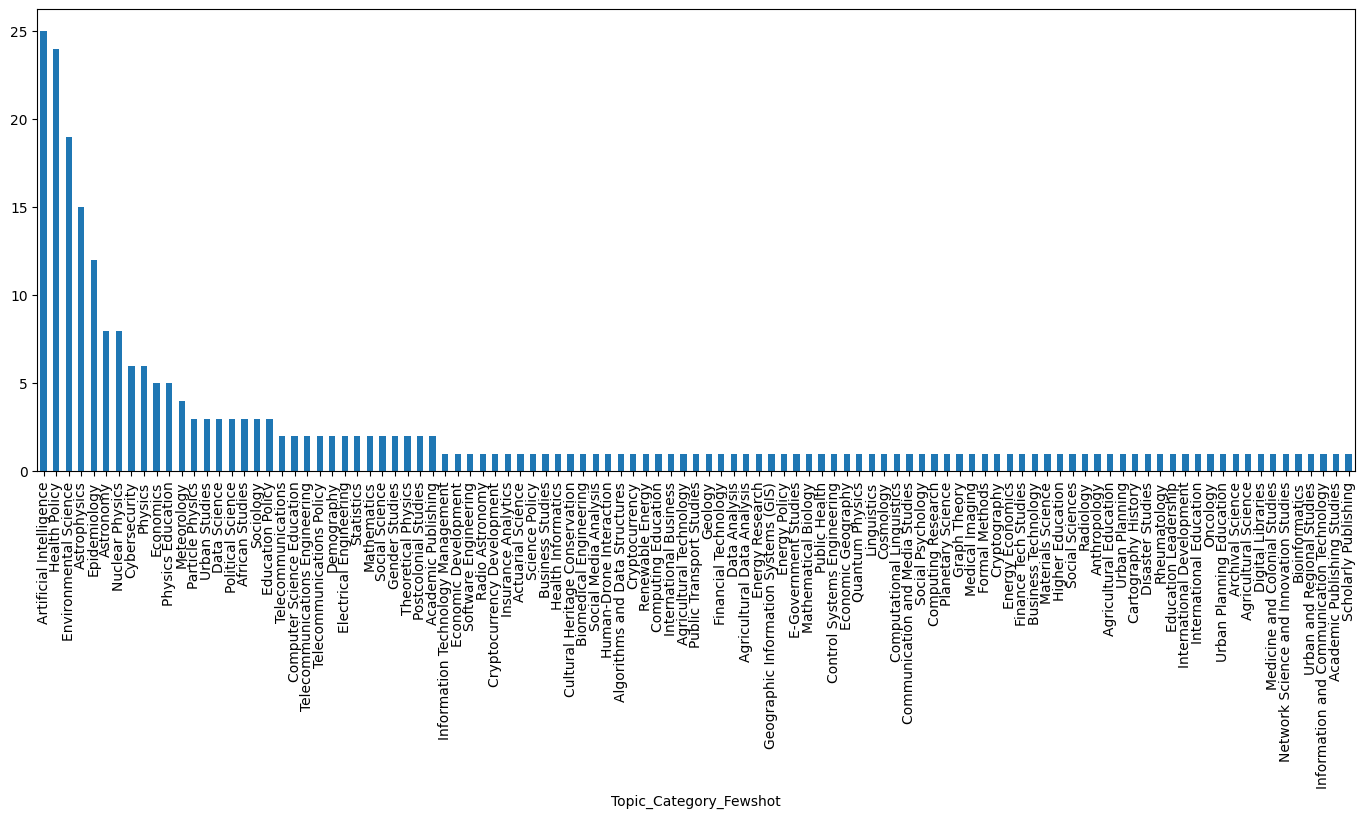

In [15]:
df["Topic_Category_Fewshot"].value_counts().plot(kind="bar", figsize=(17, 6));

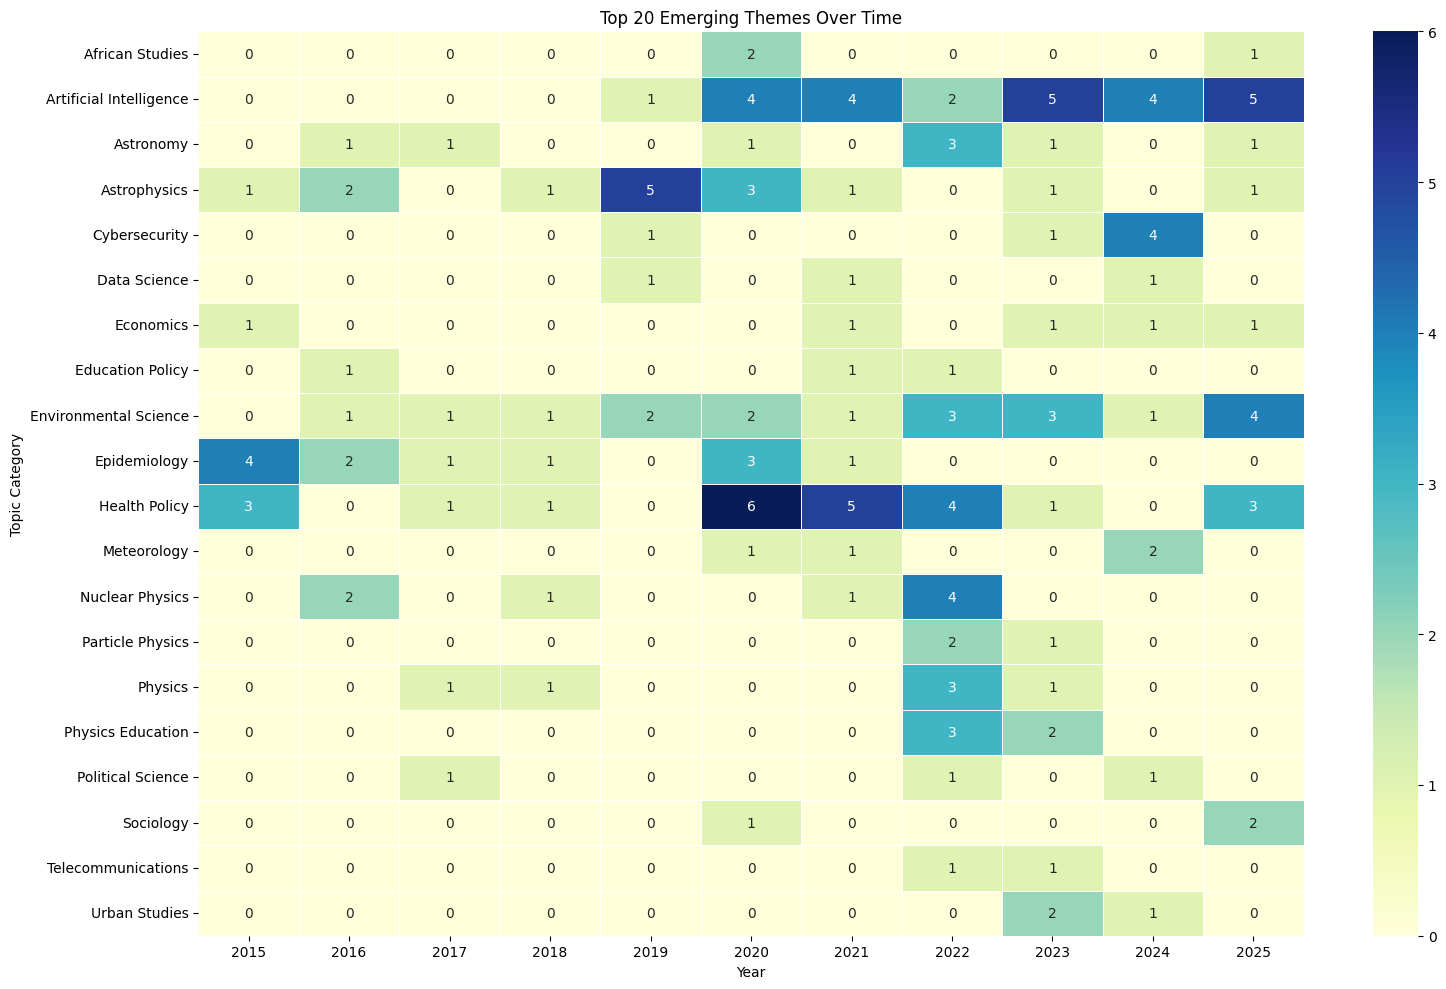

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Convert publication date to year (if needed)
df['Publication_Year'] = pd.to_datetime(df['Publication_Year'], errors='coerce').dt.year

# Step 2: Get top 20 themes
top_20_themes = df['Topic_Category_Fewshot'].value_counts().nlargest(20).index
df_top_20 = df[df['Topic_Category_Fewshot'].isin(top_20_themes)]

# Step 3: Create pivot table (rows=Theme, cols=Year, values=Counts)
heatmap_data = df_top_20.pivot_table(index='Topic_Category_Fewshot',
                                      columns='Year',
                                      values='Title',  # or any column
                                      aggfunc='count',
                                      fill_value=0)

# Step 4: Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5, annot=True, fmt="d")
plt.title('Top 20 Emerging Themes Over Time')
plt.xlabel('Year')
plt.ylabel('Topic Category')
plt.tight_layout()
plt.show()

In [30]:
from bertopic import BERTopic

In [31]:
doc = df["Title"]

In [32]:
import openai
from bertopic.representation import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")

# Fine-tune topic representations with GPT
client = openai.OpenAI(api_key=api_key)
representation_model = OpenAI(client, model="gpt-4o-mini", chat=True)
topic_model = BERTopic(representation_model=representation_model, min_topic_size=15)

In [33]:
topics, probs = topic_model.fit_transform(doc)

topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,24,-1_African research studies,[African research studies],[An Image of Northwest Yorùbáland during World...
1,0,145,0_African Education Development,[African Education Development],[The impact of Electricity Blackouts and poor ...
2,1,47,1_Giant resonance studies,[Giant resonance studies],[Isoscalar giant monopole strength in $^{58}$N...
3,2,41,2_Infectious disease modeling,[Infectious disease modeling],[Use of Available Data To Inform The COVID-19 ...


In [34]:
topic_model.get_document_info(doc)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,A Continent-Wide Assessment of Cyber Vulnerabi...,0,0_African Education Development,[African Education Development],[The impact of Electricity Blackouts and poor ...,African Education Development,0.957754,False
1,Physics Masterclasses in Africa and the World,0,0_African Education Development,[African Education Development],[The impact of Electricity Blackouts and poor ...,African Education Development,0.839459,False
2,Modelling spatio-temporal trends of air pollut...,-1,-1_African research studies,[African research studies],[An Image of Northwest Yorùbáland during World...,African research studies,0.000000,False
3,Radio astronomy in Africa: the case of Ghana,-1,-1_African research studies,[African research studies],[An Image of Northwest Yorùbáland during World...,African research studies,0.000000,False
4,Modelling the impact of vaccination on the COV...,2,2_Infectious disease modeling,[Infectious disease modeling],[Use of Available Data To Inform The COVID-19 ...,Infectious disease modeling,1.000000,False
...,...,...,...,...,...,...,...,...
252,Information and communication technology as a ...,0,0_African Education Development,[African Education Development],[The impact of Electricity Blackouts and poor ...,African Education Development,1.000000,False
253,Systematic review on the conservation genetics...,0,0_African Education Development,[African Education Development],[The impact of Electricity Blackouts and poor ...,African Education Development,1.000000,False
254,Postcolonial Reverberations,0,0_African Education Development,[African Education Development],[The impact of Electricity Blackouts and poor ...,African Education Development,0.957677,False
255,Publishing patterns at the Cape Peninsula Univ...,0,0_African Education Development,[African Education Development],[The impact of Electricity Blackouts and poor ...,African Education Development,1.000000,False


In [35]:
topic_model.generate_topic_labels()

['-1_African research studies',
 '0_African Education Development',
 '1_Giant resonance studies',
 '2_Infectious disease modeling']

In [36]:
topic_model.visualize_topics(topics=[2])

In [37]:
topic_model.visualize_barchart(topics=[0, 1, 2])

FEWSHOT WITH COT CATEGORIZATION ANALYSIS

In [16]:
df["Topic_Category_Fewshot_COT"].value_counts()

Topic_Category_Fewshot_COT
Astrophysics                       17
Epidemiology                       17
Public Health                      11
Nuclear Physics                     9
Computational Linguistics           7
                                   ..
Higher Education Administration     1
Information Systems                 1
Conservation Biology                1
Postcolonial Studies                1
Academic Publishing                 1
Name: count, Length: 132, dtype: int64

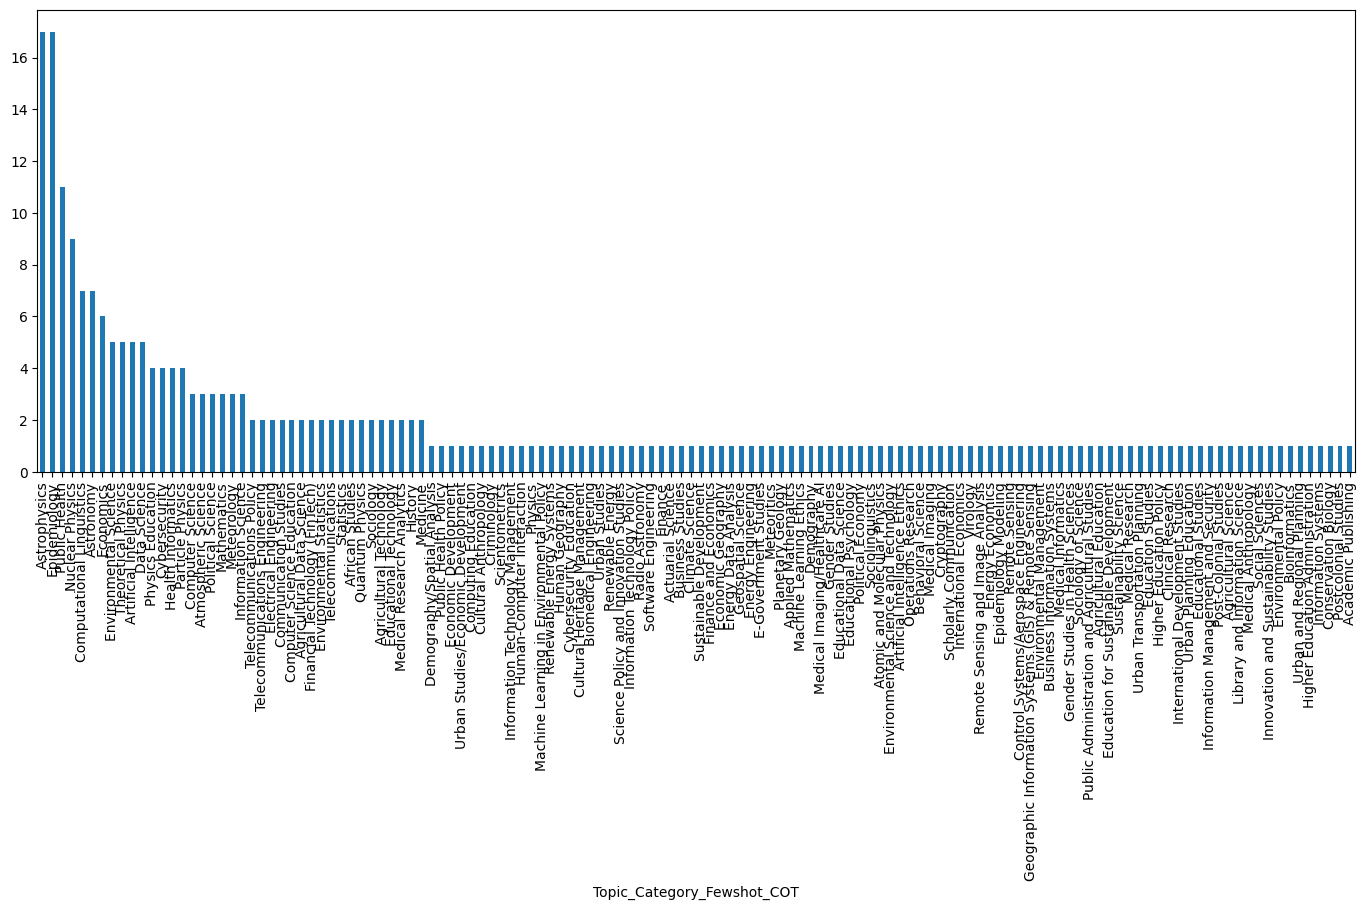

In [17]:
df["Topic_Category_Fewshot_COT"].value_counts().plot(kind="bar", figsize=(17, 6));

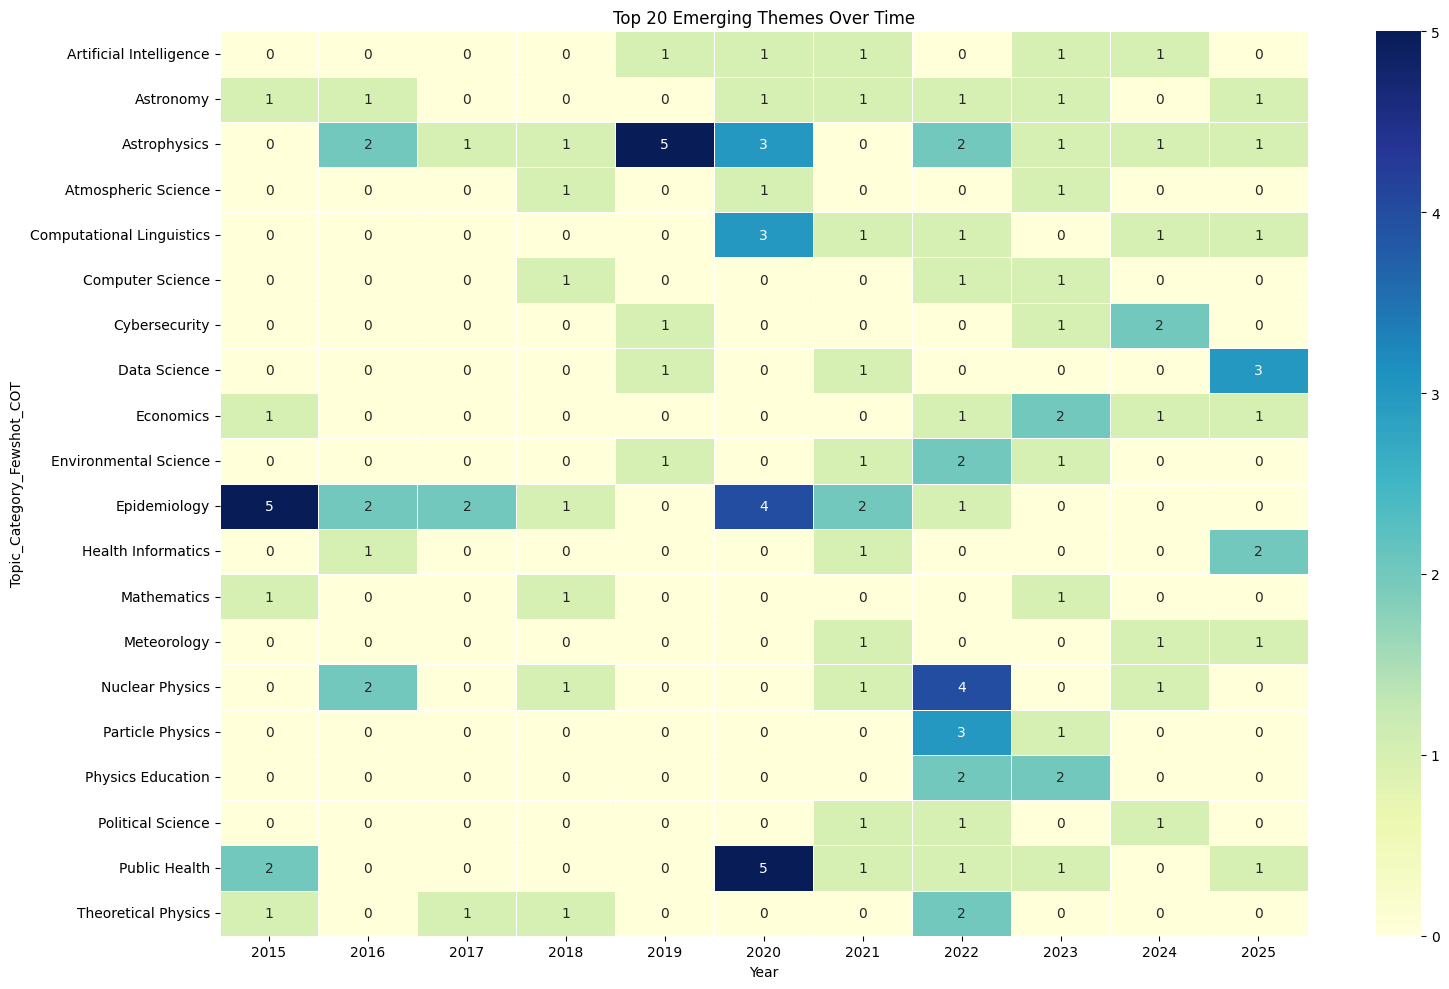

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Convert publication date to year (if needed)
df['Publication_Year'] = pd.to_datetime(df['Publication_Year'], errors='coerce').dt.year


# Step 2: Get top 20 themes
top_20_themes = df['Topic_Category_Fewshot_COT'].value_counts().nlargest(20).index
df_top_20 = df[df['Topic_Category_Fewshot_COT'].isin(top_20_themes)]

# Step 3: Create pivot table (rows=Theme, cols=Year, values=Counts)
heatmap_data = df_top_20.pivot_table(index='Topic_Category_Fewshot_COT',
                                      columns='Year',
                                      values='Title',  # or any column
                                      aggfunc='count',
                                      fill_value=0)

# Step 4: Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5, annot=True, fmt="d")
plt.title('Top 20 Emerging Themes Over Time')
plt.xlabel('Year')
plt.ylabel('Topic_Category_Fewshot_COT')
plt.tight_layout()
plt.show()

In [38]:
import openai
from bertopic.representation import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")

# Fine-tune topic representations with GPT
client = openai.OpenAI(api_key=api_key)
representation_model = OpenAI(client, model="gpt-4o-mini", chat=True)
topic_model = BERTopic(representation_model=representation_model, min_topic_size=15)

In [40]:
doc = df["Title"]

In [41]:
topics, probs = topic_model.fit_transform(doc)

topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,20,-1_Cultural and regional studies,[Cultural and regional studies],[Analysis of Modal Split of Intra-urban Trips ...
1,0,148,0_Capacity Development in Africa,[Capacity Development in Africa],[The impact of Electricity Blackouts and poor ...
2,1,48,1_Giant resonance phenomena,[Giant resonance phenomena],[Isoscalar giant monopole strength in $^{58}$N...
3,2,41,2_Infectious disease modelling,[Infectious disease modelling],[Use of Available Data To Inform The COVID-19 ...


In [42]:
topic_model.get_document_info(doc)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,A Continent-Wide Assessment of Cyber Vulnerabi...,0,0_Capacity Development in Africa,[Capacity Development in Africa],[The impact of Electricity Blackouts and poor ...,Capacity Development in Africa,1.0,False
1,Physics Masterclasses in Africa and the World,0,0_Capacity Development in Africa,[Capacity Development in Africa],[The impact of Electricity Blackouts and poor ...,Capacity Development in Africa,1.0,False
2,Modelling spatio-temporal trends of air pollut...,-1,-1_Cultural and regional studies,[Cultural and regional studies],[Analysis of Modal Split of Intra-urban Trips ...,Cultural and regional studies,0.0,False
3,Radio astronomy in Africa: the case of Ghana,-1,-1_Cultural and regional studies,[Cultural and regional studies],[Analysis of Modal Split of Intra-urban Trips ...,Cultural and regional studies,0.0,False
4,Modelling the impact of vaccination on the COV...,2,2_Infectious disease modelling,[Infectious disease modelling],[Use of Available Data To Inform The COVID-19 ...,Infectious disease modelling,1.0,False
...,...,...,...,...,...,...,...,...
252,Information and communication technology as a ...,0,0_Capacity Development in Africa,[Capacity Development in Africa],[The impact of Electricity Blackouts and poor ...,Capacity Development in Africa,1.0,False
253,Systematic review on the conservation genetics...,0,0_Capacity Development in Africa,[Capacity Development in Africa],[The impact of Electricity Blackouts and poor ...,Capacity Development in Africa,1.0,False
254,Postcolonial Reverberations,0,0_Capacity Development in Africa,[Capacity Development in Africa],[The impact of Electricity Blackouts and poor ...,Capacity Development in Africa,1.0,False
255,Publishing patterns at the Cape Peninsula Univ...,0,0_Capacity Development in Africa,[Capacity Development in Africa],[The impact of Electricity Blackouts and poor ...,Capacity Development in Africa,1.0,False


In [43]:
topic_model.generate_topic_labels()

['-1_Cultural and regional studies',
 '0_Capacity Development in Africa',
 '1_Giant resonance phenomena',
 '2_Infectious disease modelling']

In [44]:
topic_model.visualize_topics(topics=[2])

In [45]:
topic_model.visualize_barchart(topics=[0, 1, 2])

CREATING WORD CLOUD DIAGRAM

In [51]:
list_of_words = ["Discplines", "Thematic Mapping", "Themes", "LLMs", "prompt-techniques", "prompt", "Artificial Intelligence", 
                 "Africa"]

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

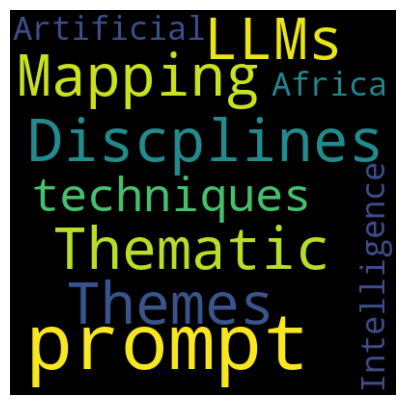

In [62]:
# converting the list to strings
words = ""
for i in list_of_words:
    words +=  i + " "

# creating the wordcloud
wordcloud = WordCloud(width=400, height=400, background_color="black").generate(words)

# Displaying the wordcloud created
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

# Saving the wordcloud image
wordcloud.to_file("wordcloud.png")

In [64]:
# Performing Chi-square test on the topic category column
from scipy.stats import chisquare

observed = df["Topic_Category"].value_counts().sort_index()

expected = [observed.sum() / len(observed)] * len(observed)

chi_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

print(f"Chi-Square Statistic: {chi_stat}")
print(f"P-value: {p_value}")

Chi-Square Statistic: 442.9688715953307
P-value: 1.3808325706239693e-53


In [69]:
# Contribution per category
contribution = (observed - expected)**2 / expected
contribution = contribution.sort_values(ascending=False)

print("Top contributing topic categories:")
print(contribution[:10])


Top contributing topic categories:
Topic_Category
Computer Science                   138.206482
Astrophysics                        54.844614
Economics                           39.918544
Epidemiology                        39.918544
Physics                             39.918544
Public Health                       33.342668
Environmental Science               17.163680
Astronomy                            6.307649
Nuclear Physics                      3.871851
Library and Information Science      2.027493
Name: count, dtype: float64


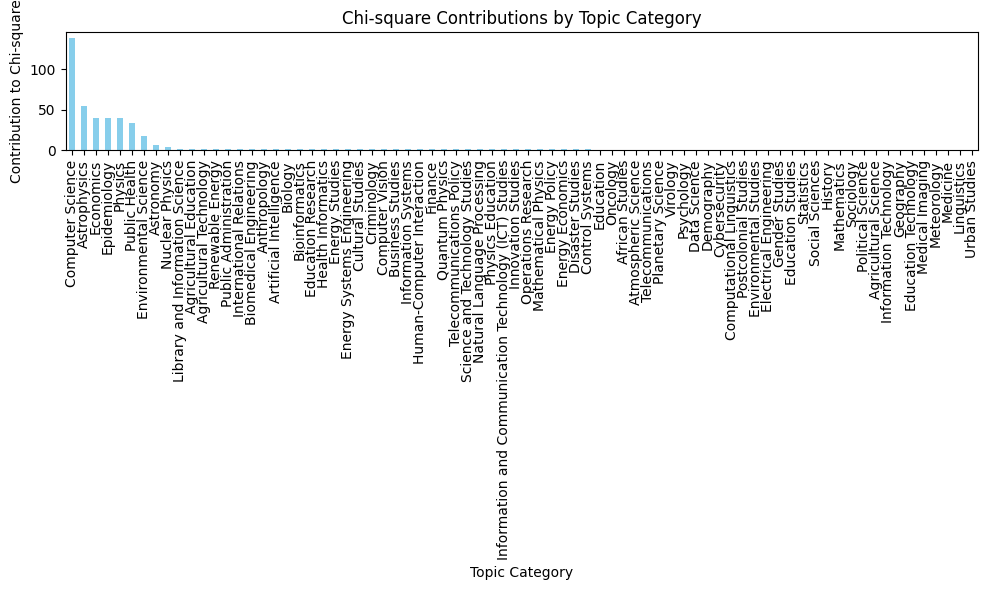

In [68]:
plt.figure(figsize=(10, 6))
contribution.plot(kind='bar', color='skyblue', title='Chi-square Contributions by Topic Category')
plt.ylabel('Contribution to Chi-square')
plt.xlabel('Topic Category')
plt.tight_layout()
plt.show()